
=== 24-h vs. stay stats (preview) ===
Shape: (56831, 78)
         HeartRate_mean_24h  RespRate_mean_24h  SBP_mean_24h  DBP_mean_24h  Temp_mean_24h  SpO2_mean_24h  BUN_mean_24h  Creatinine_mean_24h  Glucose_mean_24h  WBC_mean_24h  GCS_Eye_mean_24h  GCS_Verbal_mean_24h  GCS_Motor_mean_24h  HeartRate_min_24h  RespRate_min_24h  SBP_min_24h  DBP_min_24h  Temp_min_24h  SpO2_min_24h  BUN_min_24h  Creatinine_min_24h  Glucose_min_24h  WBC_min_24h  GCS_Eye_min_24h  GCS_Verbal_min_24h  GCS_Motor_min_24h  HeartRate_max_24h  RespRate_max_24h  SBP_max_24h  DBP_max_24h  Temp_max_24h  SpO2_max_24h  BUN_max_24h  Creatinine_max_24h  Glucose_max_24h  WBC_max_24h  GCS_Eye_max_24h  GCS_Verbal_max_24h  GCS_Motor_max_24h  HeartRate_mean_stay  RespRate_mean_stay  SBP_mean_stay  DBP_mean_stay  Temp_mean_stay  SpO2_mean_stay  BUN_mean_stay  Creatinine_mean_stay  Glucose_mean_stay  WBC_mean_stay  GCS_Eye_mean_stay  GCS_Verbal_mean_stay  GCS_Motor_mean_stay  HeartRate_max_stay  RespRate_max_stay  SBP_max_stay  D

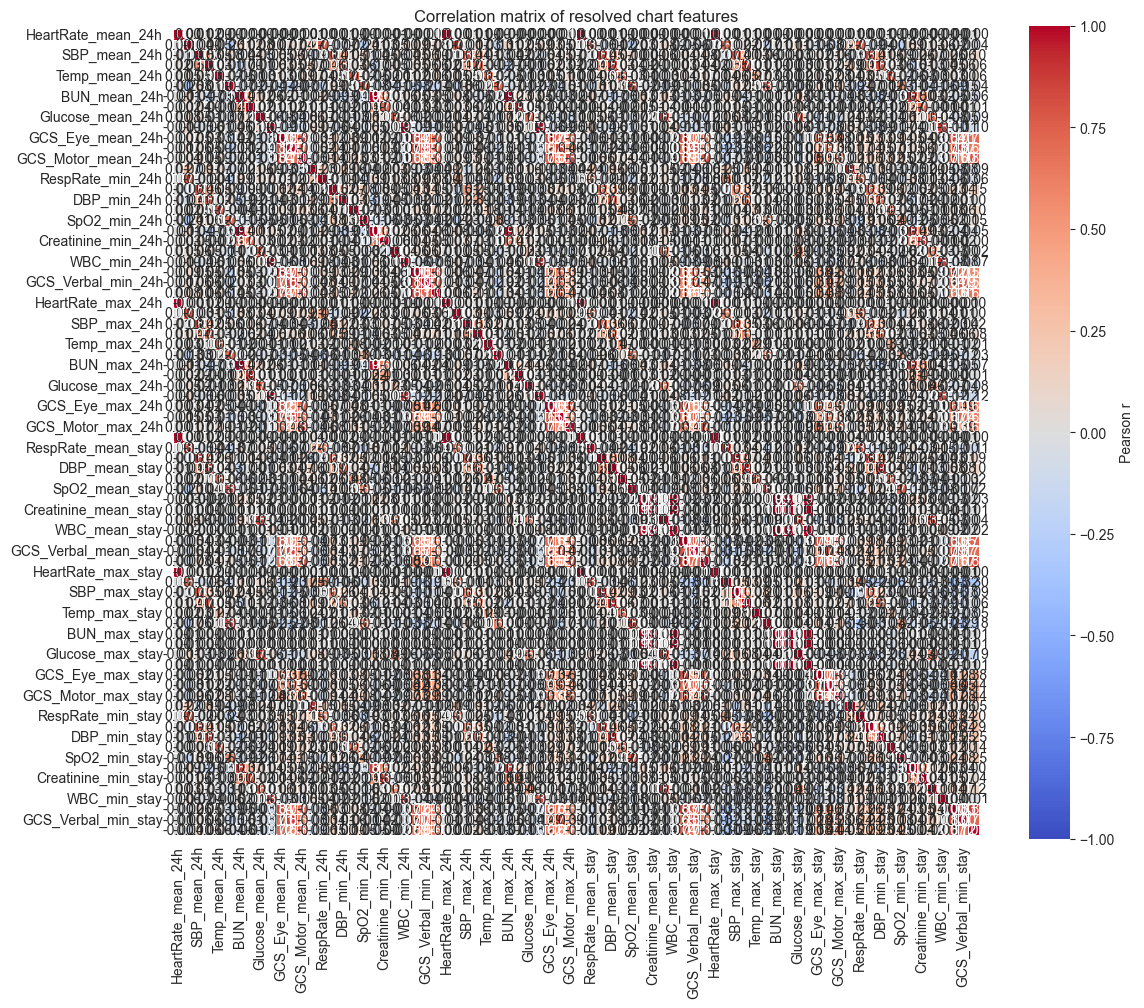

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
# metric ITEMID map
chart_itemids = {
    "HeartRate":     [220045,211],
    "RespRate":      [224689, 224690, 220210, 618, 614, 615],
    # "FiO2":          [190],
    # "GCS_Total":     [198],
    "SBP":           [220179,220050, 455, 51],
    "DBP":           [220180, 220051, 8441, 8368],
    # "NIBP":          [220181],
    "Temp":          [223761, 678],
    "SpO2":          [220277, 646], # oxygen saturation
    "BUN":           [225624, 781],
    "Creatinine":    [220615, 791],
    "Glucose":       [225664, 807, 811],
    "WBC":           [220546, 1127, 861, 1542],
    "GCS_Eye":       [220739, 184],
    "GCS_Verbal":    [223900, 723],
    "GCS_Motor":     [223901, 454]
}
# load files
wanted = [iid for sub in chart_itemids.values() for iid in sub]
chunks  = pd.read_csv(
    '../data/CHARTEVENTS.csv',
    usecols=['HADM_ID','ITEMID','VALUENUM','CHARTTIME'],
    dtype={'ITEMID':'int32','HADM_ID':'int32'},
    parse_dates=['CHARTTIME'],
    chunksize=1_000_000           # ← streams 1 M rows at a time
)
chart_values = pd.concat(
    (c[c.ITEMID.isin(wanted)] for c in chunks),
    ignore_index=True
)
admissions = pd.read_csv("../data/ADMISSIONS.csv")


all_tracked_ids = [iid for lst in chart_itemids.values() for iid in lst]
zero_mask = (chart_values["VALUENUM"] == 0) & chart_values["ITEMID"].isin(all_tracked_ids)
chart_values.loc[zero_mask, "VALUENUM"] = np.nan
# same metric varied value conflict resolver
conflict_counts = defaultdict(int)
printed_counts  = defaultdict(int)

# datetime prep
itemid_to_metric = {iid: m for m, ids in chart_itemids.items() for iid in ids}
admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"])
chart_values["CHARTTIME"] = pd.to_datetime(chart_values["CHARTTIME"])

chart_values = chart_values.merge(
    admissions[["HADM_ID", "ADMITTIME"]],
    on="HADM_ID",
    how="left"
)
chart_values["hours_since_admit"] = (
    (chart_values["CHARTTIME"] - chart_values["ADMITTIME"])
    .dt.total_seconds() / 3600.0
)

chart_values["Metric"] = chart_values["ITEMID"].map(itemid_to_metric)
chart_values = chart_values.dropna(subset=["Metric"])

# 24 hours vs. whole stay stats
chart_values["hour_int"] = chart_values["hours_since_admit"].astype(int)

hourly_vals = (
    chart_values
        .groupby(["HADM_ID", "hour_int", "ITEMID"])["VALUENUM"]
        .median()                  # collapse dup events within hour
        .unstack("ITEMID")         # (adm,hour) × ITEMID
)

resolved_hourly = pd.DataFrame(index=hourly_vals.index)
def _nz(s):  # “non-zero”
    return s.replace(0, np.nan)
# ---------- Heart Rate -------------------------------------------------
resolved_hourly["HeartRate"] = (
    _nz(hourly_vals[220045])            # MetaVision
        .combine_first(_nz(hourly_vals[211]))  # CareVue
)

# ---------- Respiratory Rate -------------------------------------------
rr_cols = [224689, 224690, 220210, 618, 614, 615]
rr = _nz(hourly_vals[rr_cols])
rr_valid = rr.mask((rr < 4) | (rr > 80))

resolved_hourly["RespRate"] = rr_valid.median(axis=1)
# ---------- Systolic / Diastolic BP ------------------------------------
def _arterial_vs_cuff(art_ids, cuff_ids, lo=50, hi=250):
    art  = _nz(hourly_vals[art_ids]).median(axis=1).clip(lo, hi)
    cuff = _nz(hourly_vals[cuff_ids]).median(axis=1).clip(lo, hi)
    return art.combine_first(cuff)

resolved_hourly["SBP"] = _arterial_vs_cuff([220050, 51], [220179, 455], lo=50, hi=250)
resolved_hourly["DBP"] = _arterial_vs_cuff([220051, 8368], [220180, 8441], lo=30, hi=150)

# ---------- NIBP mean ---------------------------------------------------
# resolved_hourly["NIBP"] = _nz(hourly_vals[220181])
# ---------- Temperature -------------------------------------------------
resolved_hourly["Temp"] = (
    _nz(hourly_vals[223761])        # MetaVision
        .combine_first(_nz(hourly_vals[678]))  # CareVue
)

# ---------- SpO2 --------------------------------------------------------
mv_spo2 = _nz(hourly_vals[220277]).where(lambda s: s.between(50, 100))
cv_spo2 = _nz(hourly_vals[646]).where(lambda s: s.between(50, 100))
spo2_diff = (mv_spo2 - cv_spo2).abs()

resolved_hourly["SpO2"] = (
    mv_spo2.combine_first(cv_spo2)                   # if only one source
        .where(mv_spo2.isna() | cv_spo2.isna() | (spo2_diff < 2),  # else:
               np.minimum(mv_spo2, cv_spo2))         # take lower of the two
)
# ---------- BUN & Creatinine -------------------------------------------
resolved_hourly["BUN"] = (
    _nz(hourly_vals[225624]).combine_first(_nz(hourly_vals[781]))
)
resolved_hourly["Creatinine"] = (
    _nz(hourly_vals[220615]).combine_first(_nz(hourly_vals[791]))
)

# ---------- Glucose -----------------------------------------------------
lab_glu = _nz(hourly_vals[811])                       # serum
fs_glu  = _nz(hourly_vals[[225664, 807]]).median(axis=1)  # finger-stick median
resolved_hourly["Glucose"] = lab_glu.combine_first(fs_glu)

# ---------- WBC ---------------------------------------------------------
resolved_hourly["WBC"] = (
    _nz(hourly_vals[220546])      # MetaVision
        .combine_first(_nz(hourly_vals[[1127, 861, 1542]]).median(axis=1))
)

# ---------- GCS components ---------------------------------------------
resolved_hourly["GCS_Eye"] = _nz(hourly_vals[[220739, 184]]).min(axis=1)
resolved_hourly["GCS_Verbal"] = _nz(hourly_vals[[223900, 723]]).min(axis=1)
resolved_hourly["GCS_Motor"] = _nz(hourly_vals[[223901, 454]]).min(axis=1)

resolved_hourly = resolved_hourly.reset_index()
# first 24 hours # min max
first24 = resolved_hourly[resolved_hourly["hour_int"] < 24]
f24_mean = first24.groupby("HADM_ID").mean(numeric_only=True).add_suffix("_mean_24h")
# f24_std  = first24.groupby("HADM_ID").std(numeric_only=True).add_suffix("_std_24h")
f24_max = (
    first24.groupby('HADM_ID').max(numeric_only=True).add_suffix('_max_24h')
)
f24_min = (
    first24.groupby('HADM_ID').min(numeric_only=True).add_suffix('_min_24h')
)
first24_stats = pd.concat([f24_mean, f24_min, f24_max], axis=1)

# stay - daily mean
resolved_hourly["day_int"] = resolved_hourly["hour_int"] // 24
daily_means = (
    resolved_hourly
        .groupby(["HADM_ID", "day_int"])
        .mean(numeric_only=True)
)

stay_mean = daily_means.groupby("HADM_ID").mean(numeric_only=True).add_suffix("_mean_stay")
# stay_std  = daily_means.groupby("HADM_ID").std(numeric_only=True).add_suffix("_std_stay")
stay_min = daily_means.groupby('HADM_ID').min(numeric_only=True).add_suffix('_min_stay')
stay_max = daily_means.groupby('HADM_ID').max(numeric_only=True).add_suffix('_max_stay')
whole_stats = pd.concat([stay_mean, stay_max, stay_min], axis=1)

# combine & difference
combined_stats = first24_stats.join(whole_stats, how="outer")
hour_cols = [c for c in combined_stats.columns if "hour_int" in c]
combined_stats = combined_stats.drop(columns=hour_cols)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
print("\n=== 24-h vs. stay stats (preview) ===")
print(f"Shape: {combined_stats.shape}")
print(combined_stats.head(10))
pd.reset_option("display.max_columns")
pd.reset_option("display.width")

combined_stats.to_csv("chart_stats_24h_vs_stay.csv")

# LOS diatribution
chart_values["DATE"] = chart_values["CHARTTIME"].dt.normalize()
days_per_adm = (
    chart_values.groupby("HADM_ID")["DATE"]
    .nunique()
    .rename("ChartDaysRecorded")
)

print("\n=== Number of chart-recorded days per admission (head) ===")
print(days_per_adm.head(20))

print("\nSummary of the days distribution")
print(days_per_adm.agg(["min", "max", "mean", "median"]).to_frame("Value"))

bins    = [0, 7, 14, np.inf]
labels  = ["<7 days", "7–14 days", ">14 days"]
bucket  = pd.cut(days_per_adm, bins=bins, right=False, labels=labels)
bucket_counts = bucket.value_counts().sort_index()
bucket_pct    = (bucket_counts / len(days_per_adm) * 100).round(2)
print("\n=== LOS bucket distribution ===")
print(pd.DataFrame({"Admissions": bucket_counts, "Percent_%": bucket_pct}))

# correlation heat map
num_cols = combined_stats.select_dtypes('number')
num_cols = num_cols.dropna(how='all')
# identify hour_int‑based features and drop them
hour_cols         = [c for c in num_cols.columns if c.startswith("hour_int")]
num_cols_no_hour  = num_cols.drop(columns=hour_cols, errors="ignore")

# compute correlation on the remaining features
corr = num_cols_no_hour.corr(method="pearson")
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, vmin=-1, vmax=1, center=0, cmap="coolwarm", square=True,
    linewidths=0.5, cbar_kws={"label": "Pearson r"},
    annot=True, fmt=".2f"
)
plt.title("Correlation matrix of resolved chart features")
plt.tight_layout()
plt.savefig("chart_feature_correlations.png", dpi=300)
plt.show()